In [1]:
import numpy as np
from scipy import linalg
from collections import defaultdict

In [2]:
#Utils

#Tính hàm sigmoid
def sigmoid(z):
  return 1/(1+np.exp(-z))

#Trả về vị trí của các từ trong 1 list cho trước và biết trước vị trí của từ đó trong list khác
def get_idx(words, word2Idx):
  idx=[]
  for word in words:
    idx=idx+[word2Idx[word]]
  return idx

#Trả về list bao gồm các cặp (idx, freq) của context_words
def pack_idx_with_frequency(context_words, word2Idx):
  freq_dict=defaultdict(int)
  for word in context_words:
    freq_dict[word]+=1
  
  idxs=get_idx(context_words, word2Idx)
  pack=[]
  for i in range(len(idxs)):
    idx=idxs[i]
    freq=freq_dict[context_words[i]]
    pack.append((idx, freq))
  return pack

#sliding windiow
#C: số từ neighbor left hoặc right
#V: số lượng từ vựng có trong data
def get_vectors(data,word2Ind, V, C):
  i=C
  while True:
    y=np.zeros(V)
    x=np.zeros(V)
    center_word=data[i]
    y[word2Ind[center_word]]=1
    context_words=data[(i-C):i]+data[(i+1):(i+C+1)]
    num_cxt_words=len(context_words)

    for idx, freq in pack_idx_with_frequency(context_words, word2Ind):
      x[idx]=freq/num_cxt_words
    
    yield x, y
    i+=1
    if i>=len(data):
      print("i being set to 0")
      i=0

#Tạo batch cho việc training
def get_batches(data, word2Ind, V, C, batch_size):
  batch_x=[]
  batch_y=[]
  for x, y in get_vectors(data, word2Ind, V, C):
    while len(batch_x)<batch_size:
      batch_x.append(x)
      batch_y.append(y)
    else:
      yield np.array(batch_x).T, np.array(batch_y).T #Column vector 
      batch=[]

#Dùng PCA để giảm chiều dữ liệu để visualization
def compute_pca(data, n_components=2):
  #Input data+components -> X_reduced
  #data: data matrix (m, n) mỗi hàng là 1 word vector
  m,n=data.shape
  data-=data.mean(axis=0)
  R=np.cov(data, rowvar=False)
  evals, evecs=linalg.eigh(R)
  idx=np.argsort(evals)[::-1]
  evecs=evecs[:, idx]
  evals=evals[idx]
  evecs=evecs[:, :n_components]
  return np.dot(evecs.T, data.T).T

#Return lists: word2Ind, Ind2word
def get_dict(data):
  words=sorted(list(set(data))) #vocabulary
  n=len(words)
  idx=0
  word2Ind={}
  Ind2word={}
  for k in words:
    word2Ind[k]=idx
    Ind2word[idx]=k
    idx+=1
  return word2Ind, Ind2word


In [3]:
#Download data
!wget https://raw.githubusercontent.com/ijelliti/Deeplearning.ai-Natural-Language-Processing-Specialization/master/2%20-%20Natural%20Language%20Processing%20with%20Probabilistic%20Models/Labs/Week%204/shakespeare.txt

--2020-09-29 14:48:18--  https://raw.githubusercontent.com/ijelliti/Deeplearning.ai-Natural-Language-Processing-Specialization/master/2%20-%20Natural%20Language%20Processing%20with%20Probabilistic%20Models/Labs/Week%204/shakespeare.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 306996 (300K) [text/plain]
Saving to: ‘shakespeare.txt.5’

shakespeare.txt.5   100%[===================>] 299.80K  --.-KB/s    in 0.04s   

2020-09-29 14:48:18 (6.70 MB/s) - ‘shakespeare.txt.5’ saved [306996/306996]



In [4]:
#Import Python library
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
from collections import Counter



In [5]:
# Download sentence tokenizer
nltk.data.path.append('.')

In [6]:
# Load, tokenize and process the data
import re                                                           #  Load the Regex-modul
with open('shakespeare.txt') as f:
    data = f.read()                                                 #  Read in the data
data = re.sub(r'[,!?;-]', '.',data)                                 #  Punktuations are replaced by .
data = nltk.word_tokenize(data)                                     #  Tokenize string to words
data = [ ch.lower() for ch in data if ch.isalpha() or ch == '.']    #  Lower case and drop non-alphabetical tokens
print("Number of tokens:", len(data),'\n', data[:15]) 

Number of tokens: 60933 
 ['o', 'for', 'a', 'muse', 'of', 'fire', '.', 'that', 'would', 'ascend', 'the', 'brightest', 'heaven', 'of', 'invention']


In [7]:
#Compute the frequency distributions of words in the dataset (vocabulary)
fdist=nltk.FreqDist(word for word in data)
print(len(fdist))
print(fdist.most_common(30))


5772
[('.', 9630), ('the', 1521), ('and', 1394), ('i', 1252), ('to', 1159), ('of', 1093), ('my', 857), ('that', 781), ('in', 770), ('you', 748), ('a', 742), ('is', 630), ('not', 559), ('for', 467), ('it', 460), ('with', 441), ('his', 434), ('but', 417), ('me', 417), ('your', 397), ('be', 395), ('thy', 359), ('this', 355), ('he', 353), ('so', 352), ('thou', 332), ('have', 327), ('as', 315), ('her', 281), ('him', 277)]


In [8]:
word2Ind, Ind2word=get_dict(data)
print("Size of vocabulary: ", len(word2Ind))

Size of vocabulary:  5772


In [9]:
# example of word to index mapping
print("Index of the word 'king' :  ",word2Ind['king'] )
print("Word which has index 2743:  ",Ind2word[2743] )

Index of the word 'king' :   2743
Word which has index 2743:   king


In [10]:
def initialize_model(N,V, random_seed=1):
    np.random.seed(random_seed)
    # W1 has shape (N,V)
    W1 = np.random.rand(N, V)
    # W2 has shape (V,N)
    W2 = np.random.rand(V, N)
    # b1 has shape (N,1)
    b1 = np.random.rand(N,1)
    # b2 has shape (V,1)
    b2 = np.random.rand(V,1)
    return W1, W2, b1, b2

In [11]:
def softmax(z):
    y_=np.exp(z)
    yhat = y_/np.sum(y_, axis=0, keepdims=True)
    return yhat

In [12]:
def forward_prop(x, W1, W2, b1, b2):
    h = np.dot(W1, x)+b1
    h=np.maximum(h,0)
    z = np.dot(W2,h)+b2
    return z, h

In [13]:
def compute_cost(y, yhat, batch_size):
    # cost function 
    logprobs = np.multiply(np.log(yhat),y) + np.multiply(np.log(1 - yhat), 1 - y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    # Compute l1 as W2^T (Yhat - Y)
    # Re-use it whenever you see W2^T (Yhat - Y) used to compute a gradient
    l1 = W2.T @ (yhat-y)
    # Apply relu to l1
    l1 = np.maximum(l1,0)
    # Compute the gradient of W1
    grad_W1 = (1/batch_size)*np.dot(np.maximum(np.dot(W2.T,yhat-y),0), x.T) 
    # Compute the gradient of W2
    grad_W2 = (1/batch_size)*np.dot(yhat-y, h.T)
    # Compute the gradient of b1
    grad_b1 = (1/batch_size)*np.sum(np.maximum(np.dot(W2.T, yhat-y), 0), axis=1, keepdims=True)
    # Compute the gradient of b2
    grad_b2 = (1/batch_size)*np.sum((yhat-y), axis=1, keepdims=True)
    return grad_W1, grad_W2, grad_b1, grad_b2

In [14]:
def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03):
    W1, W2, b1, b2 = initialize_model(N,V, random_seed=282)
    batch_size = 128
    iters = 0
    C = 2
    for x, y in get_batches(data, word2Ind, V, C, batch_size):
        # Get z and h
        z, h = forward_prop(x, W1, W2, b1, b2)
        # Get yhat
        yhat = softmax(z)
        # Get cost
        cost = compute_cost(y, yhat, batch_size)
        if ( (iters+1) % 10 == 0):
            print(f"iters: {iters + 1} cost: {cost:.6f}")
        # Get gradients
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)
        
        # Update weights and biases
        W1 = W1- alpha*grad_W1
        W2 = W2- alpha*grad_W2
        b1 = b1- alpha*grad_b1
        b2 = b2- alpha*grad_b2
        
        iters += 1 
        if iters == num_iters: 
            break
        if iters % 100 == 0:
            alpha *= 0.66
            
    return W1, W2, b1, b2

In [15]:
C = 2
N = 50
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 200
print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters)

Call gradient_descent
iters: 10 cost: 0.543259
iters: 20 cost: 0.105205
iters: 30 cost: 0.057815
iters: 40 cost: 0.039841
iters: 50 cost: 0.030391
iters: 60 cost: 0.024565
iters: 70 cost: 0.020614
iters: 80 cost: 0.017758
iters: 90 cost: 0.015598
iters: 100 cost: 0.013906
iters: 110 cost: 0.012934
iters: 120 cost: 0.012129
iters: 130 cost: 0.011417
iters: 140 cost: 0.010785
iters: 150 cost: 0.010219
iters: 160 cost: 0.009709
iters: 170 cost: 0.009248
iters: 180 cost: 0.008829
iters: 190 cost: 0.008446
iters: 200 cost: 0.008095


In [16]:
# visualizing the word vectors here
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['king', 'queen','lord','man', 'woman','dog','wolf',
         'rich','happy','sad']

embs = (W1.T + W2)/2.0
 
# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [word2Ind[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)  # X.shape:  Number of words of dimension N each 

(10, 50) [2743, 3947, 2959, 3021, 5669, 1452, 5668, 4186, 2315, 4273]


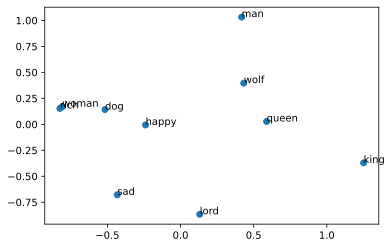

In [17]:
result= compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

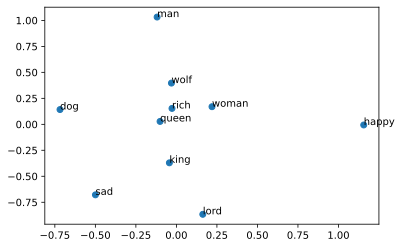

In [18]:
result= compute_pca(X, 4)
pyplot.scatter(result[:, 3], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 3], result[i, 1]))
pyplot.show()